In [1]:
from IPython.display import Image

# CNTK Time series prediction with LSTM

This demo demonstrates how to use CNTK to predict future values in a time series using a Recurrent Neural Network (RNN). It is based on a [LSTM tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_106A_LSTM_Timeseries_with_Simulated_Data.ipynb) that comes with the CNTK distribution.

RNNs are particularly well suited to learn sequence data.
For details on RNNs, see [this excellent post](http://colah.github.io/posts/2015-08-Understanding-LSTMs). 

![RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

**Goal**

We will download stock prices for a chosen symbol, then train a recurrent neural net to predict the closing price on the following  day from $N$ previous days' closing prices.

Our RNN will We will use long-Short Term Memory [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) units in the hidden layer. An LSTM network is well-suited to learn from experience to classify, process and predict time series when there are time lags of unknown size and bound between important events. 
![LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)




## Organization

The example has the following sections:
- Download and prepare data
- LSTM network modeling
- Model training and evaluation

In [2]:
# Standard packages
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time

# Helpers for reading stock prices
import pandas_datareader.data as pdr
import datetime as dt

# Images
from IPython.display import Image

# CNTK packages
import cntk as C
import cntk.axis
from cntk.layers import Input, Dense, Dropout, Recurrence 

%matplotlib inline

### Select the notebook runtime environment devices / settings

Set the device. If you have both CPU and GPU on your machine, you can optionally switch the devices.

In [3]:
# If you have a GPU, uncomment the GPU line below
#C.device.set_default_device(C.device.gpu(0))
C.device.set_default_device(C.device.cpu())

## Download and Prepare Data

Here we define helper methods to prepare the data.

### `download_data()`
Queries Yahoo Finance for daily close price of a given stock ticker symbol. Returns an array of floats.

In [4]:
def download_data1(symbol='MSFT', start=dt.datetime(2017, 1, 1), end=dt.datetime(2017, 3, 1)):
    """
    Download daily close and volume for specified stock symbol from Yahoo Finance
    Returns pandas DataFrame
    """
    data = pdr.DataReader(symbol, 'yahoo', start, end)
    data.rename(inplace = True, columns={'Close':'data'})
    rv = data['data'].diff()[1:] / 50.0
    return rv

In [5]:
def download_data(which = "milk"):
    """
    Read csv
    """
    if(which == 'temp'):
        data = pd.read_csv('mean-daily-temperature-fisher-ri.csv')
        data.rename(inplace = True, columns={'temp':'data'})
        rv = data['data']/100
    else:
        data = pd.read_csv('monthly-milk-production-pounds-p.csv')
        data.rename(inplace = True, columns={'milk':'data'})
        rv = data['data'].diff()[1:] / 50.0
    return rv

### `generate_RNN_data()`
The RNN will be trained on sequences of length $N$ of single values (scalars), meaning that each training sample is a $N\times1$ matrix. CNTK requires us to shape our input data as an array with each element being an observation. So, for inputs, $X$, we need to create a tensor or 3-D array with dimensions $[M, N, 1]$ where $M$ is the number of training samples.<br/>
As output we want our network to predict the next value of the sequence, so our target, $Y$, is a $[M, 1]$ array containing the next day's value of the stock price after the sequence presented in $X$.</br/>

We do this by sampling from the sequence of stock prices and creating numpy `ndarray`s.

In [6]:
def generate_RNN_data(x, time_steps=10):
    """
    Generate sequences to feed to rnn
    x: DataFrame, daily close
    time_steps: int, number of days in sequences used to train the RNN
    """
    
    rnn_x = []
    for i in range(len(x) - (time_steps+1)):
        # Each training sample is a sequence of length time_steps
        xi = x[i: i + time_steps].astype(np.float32).as_matrix()
        # We need to reshape as a column vector as the model expects
        # 1 float per time point
        xi = xi.reshape(-1,1)
        rnn_x.append(xi)
    rnn_x = np.array(rnn_x)
    
    # The target values are a single float per training sequence
    rnn_y = np.array(x[time_steps+1:].astype(np.float32)).reshape(-1,1)
    
    return split_data(rnn_x, 0.2, 0.2), split_data(rnn_y, 0.2, 0.2)

### `split_data()`
This function will split the data into training, validation and test sets and return a list with those elements, each containing a `ndarray` as described above.

In [7]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits np.array into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]

    return {"train": train, "val": val, "test": test}

### Execute
Download data, generate the RNN training and evaluation data and visualize

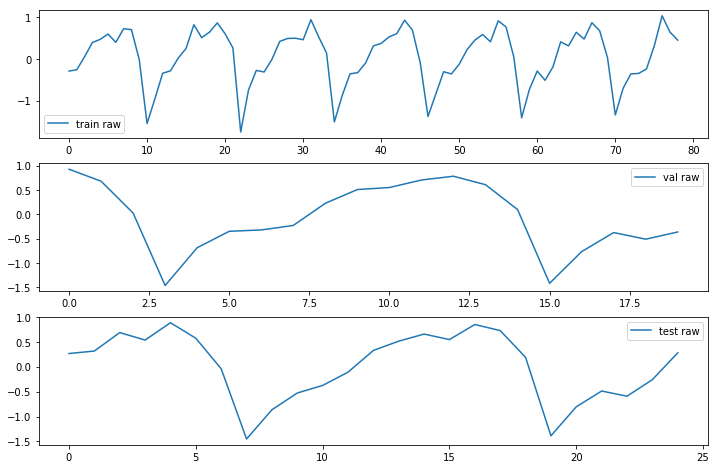

In [8]:
symbol = 'MSFT'
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2017, 3, 1)
window = 30

#raw_data = download_data1(symbol=symbol, start=start, end=end)
#rd100 = raw_data['Close']/10.0
raw_data = download_data('milk')
X, Y = generate_RNN_data(raw_data, window)

f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(['train', 'val', 'test']):
    a[j].plot(Y[ds], label=ds + ' raw')
[i.legend() for i in a];

Quick check on the dimensions of the data + make sure we don't have any NaNs

In [9]:
print([(a, X[a].shape) for a in X.keys()])
print([(a, Y[a].shape) for a in Y.keys()])
print([(a, np.isnan(X[a]).any()) for a in X.keys()])
print([(a, np.isnan(Y[a]).any()) for a in Y.keys()])

[('test', (25, 30, 1)), ('train', (79, 30, 1)), ('val', (20, 30, 1))]
[('test', (25, 1)), ('train', (79, 1)), ('val', (20, 1))]
[('test', False), ('train', False), ('val', False)]
[('test', False), ('train', False), ('val', False)]


We define the `next_batch()` iterator that produces batches we can feed to the training function. 
Note that because CNTK supports variable sequence length, we must feed the batches as list of sequences. This is a convenience function to generate small batches of data often referred to as minibatch.

In [10]:
def next_batch(x, y, ds, size=10):
    """get the next batch to process"""
    for i in range(0, len(x[ds])-size, size):
        yield np.array(x[ds][i:i+size]), np.array(y[ds][i:i+size])        

## Network modeling

We setup our network with $N$ LSTM cells, each receiving the single value of our sequence as input at every time step. The $N$ outputs from the LSTM layer are the input into a dense layer that produces a single output. So, we have 1 input, $N$ hidden LSTM nodes and again a single output node.

Between LSTM and dense layer we insert a special dropout operation that randomly ignores 20% of the values coming the LSTM *during training* to prevent overfitting. When using the model to make predictions all values will be retained.

We are only interested in predicting one step ahead when we get to the end of each training sequence, so we use another operator to identify the last item in teh sequence before connecting the output layer.

*Replace this image with own*
![lstm](https://www.cntk.ai/jup/cntk106A_model_s3.png)

Using CNTK we can easily express our model:

In [11]:
def create_model(I, H, O):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        x = C.layers.Input(I)
        m = C.layers.Recurrence(C.layers.LSTM(H))(x)
        m = C.ops.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = cntk.layers.Dense(O)(m)
    
    # Also create a layer to represent the target. It has the same number of units as the output
    # and has to share the same dynamic axes
    y = C.layers.Input(1, dynamic_axes=m.dynamic_axes, name="y")
    
    return (m, x, y)

CNTK inputs, outputs and parameters are organized as tensors, or n-dimensional arrays. CNTK refers to these different dimensions as *axes*.

Every CNTK tensor has some static axes and some dynamic axes. The static axes have the same length throughout the life of the network whereas the dynamic axes can vary in length from instance to instance.

The axis over which you run a recurrence is dynamic and thus its dimensions are unknown at the time you define your variable. Thus the input variable only lists the shapes of the static axes. Since our inputs are a sequence of one dimensional numbers we specify the input as 

```
C.layers.Input(1)
```

Both the $N$ instances in the sequence (training window) and the number of sequences that form a mini-batch are implicitly represented in the default dynamic axis as shown below in the form of defaults. 

```
x_axes = [C.Axis.default_batch_axis(), C.Axis.default_dynamic_axis()]
C.layers.Input(1, dynamic_axes=x_axes)
```

More information [here](https://www.cntk.ai/pythondocs/sequence.html).

The trainer needs definition of the loss function and the optimization algorithm.

In [12]:
def create_trainer(model, output, learning_rate = 0.001, batch_size = 20):
    # the learning rate
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

    # loss function
    loss = C.ops.squared_error(model, output)

    # use squared error for training
    error = C.ops.squared_error(model, output)

    # use adam optimizer
    momentum_time_constant = C.learner.momentum_as_time_constant_schedule(batch_size / -math.log(0.9)) 
    learner = C.learner.adam_sgd(z.parameters, 
                                 lr = lr_schedule,
                                 momentum = momentum_time_constant,
                                 unit_gain = True)

    # Construct the trainer
    return(C.Trainer(model, (loss, error), [learner]))

Setup everything else we need for training the model: define user specified training parameters, define inputs, outputs, model and the optimizer.

In [13]:
# create the model with 1 input (x), 10 LSTM units, and 1 output unit (y)
(z, x, y) = create_model(1, 10, 1)

# Construct the trainer
BATCH_SIZE = 2
trainer = create_trainer(z, y, learning_rate=0.0002, batch_size=BATCH_SIZE)

## Training the network

We are ready to train. 100 epochs should yield acceptable results.

In [14]:
# Training parameters
EPOCHS = 500

In [15]:
# train
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for x1, y1 in next_batch(X, Y, "train", BATCH_SIZE):
        trainer.train_minibatch({x: x1, y: y1})
    if epoch % (EPOCHS / 20) == 0:
        training_loss = cntk.utils.get_train_loss(trainer)
        loss_summary.append((epoch, training_loss))
        print("epoch: {}, loss: {:.5f}".format(epoch, training_loss))

loss_summary = np.array(loss_summary)

print("training took {0:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.63748
epoch: 25, loss: 0.56065
epoch: 50, loss: 0.53173
epoch: 75, loss: 0.37645
epoch: 100, loss: 0.21671
epoch: 125, loss: 0.29676
epoch: 150, loss: 0.09573
epoch: 175, loss: 0.11045
epoch: 200, loss: 0.18032
epoch: 225, loss: 0.08914
epoch: 250, loss: 0.10178
epoch: 275, loss: 0.10364
epoch: 300, loss: 0.10407
epoch: 325, loss: 0.17290
epoch: 350, loss: 0.23713
epoch: 375, loss: 0.17405
epoch: 400, loss: 0.07850
epoch: 425, loss: 0.28580
epoch: 450, loss: 0.06551
epoch: 475, loss: 0.13131
training took 108.2 sec


Let's look at how the loss function decreases over time to see if the model is converging

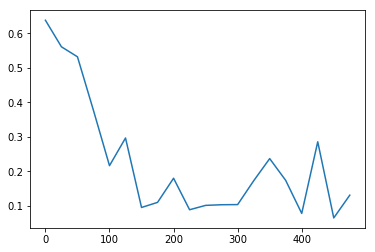

In [16]:
plt.plot(loss_summary[:,0], loss_summary[:,1], label='training loss');

Normally we would validate the training on the data that we set aside for validation but since the input data is small we can run validattion on all parts of the dataset.

In [17]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt, BATCH_SIZE):
        eval_error = trainer.test_minibatch({x:x1, y:y1})
        result += eval_error
    return result/len(X[labeltxt])

In [18]:
# Print the train and validation errors
for labeltxt in ["train", "val", 'test']:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for train: 0.043953
mse for val: 0.056695
mse for test: 0.045996


We check that the errors are roughly the same for train, validation and test sets. We also plot the expected output (Y) and the prediction our model made to shows how well the simple LSTM approach worked.

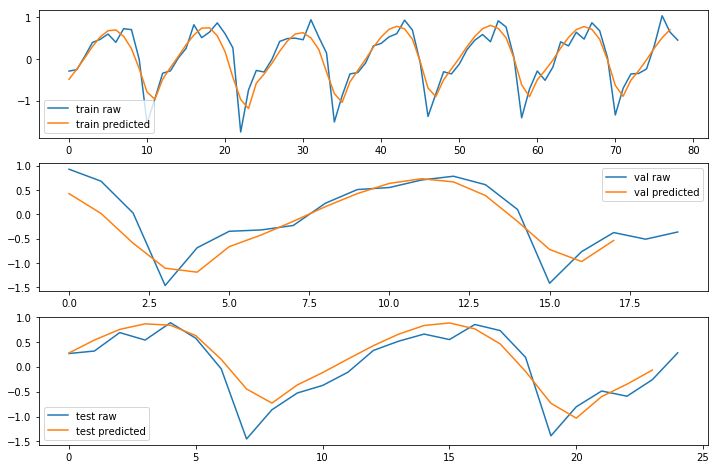

In [19]:
# predict
f, a = plt.subplots(3, 1, figsize = (12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x1, y1 in next_batch(X, Y, ds, BATCH_SIZE):
        pred = z.eval({x: x1})
        results.extend(pred[:, 0])
    a[j].plot(Y[ds], label = ds + ' raw')
    a[j].plot(results, label = ds + ' predicted')
[i.legend() for i in a];